In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import gc
import random
import warnings

from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score, log_loss, roc_curve, auc, accuracy_score, precision_score, recall_score,confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_squared_error

import os
import sys
from tqdm import tqdm_notebook as tqdm
import lightgbm as lgb
import optuna
from optuna import Trial


# ## Set python parameters
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
np.random.seed(2018)

gcol = 'real_icap_kw'


#Here for posterity
def sig(x,L=1,k=1,xo=0): #general form of logistic regression
    return L/(1 + np.e**(-k*(x-xo)))

def syndrop(x): #adds noise to synthetic drop data based on rate
    #at high x, sig approaches 1, highly likely to return a drop
    if np.random.rand() >= sig(x,k=17,xo=.17):
        return 0
    else:
        return 1  
    

#read in datasets
train = pd.read_csv("../preprocessing/output_data/train_X.csv")
train_y = pd.read_csv("../preprocessing/output_data/train_y.csv")
train_real_values = train_y[train_y.columns[0]].values
del train_y

test = pd.read_csv("../preprocessing/output_data/test_X.csv")
test_y = pd.read_csv("../preprocessing/output_data/test_y.csv")
test_real_values = test_y[test_y.columns[0]].values
del test_y

cats = np.load("../../input_data/historical/new_remapped_labels_2020_10_27.npy",allow_pickle=True).item() #label encoding dict
catsi = [list(test.columns).index(i) for i in cats]

def objective(trial: Trial, fast_check=True, target_meter=0, return_info=False):
    folds = 5
    seed = 666
    shuffle = False
    kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

    y_valid_pred_total = np.zeros(train.shape[0])

    models = []
    valid_score = 0
    for train_idx, valid_idx in kf.split(train,train_real_values):
        train_data = train.iloc[train_idx,:], train_real_values[train_idx]
        valid_data = train.iloc[valid_idx,:], train_real_values[valid_idx]

        print('train', len(train_idx), 'valid', len(valid_idx))
        model, y_pred_valid, log = fit_lgbm(trial, train_data, valid_data, cat_features=cats,seed=seed,
                                            num_rounds=3000)
        y_valid_pred_total[valid_idx] = y_pred_valid
        models.append(model)
        gc.collect()
        valid_score += log["valid/l2"]
        if fast_check:
            break
    valid_score /= len(models)
    if return_info:
        return valid_score, models, y_pred_valid, y_train
    else:
        return valid_score

# Referred https://github.com/pfnet/optuna/blob/master/examples/lightgbm_simple.py

def fit_lgbm(trial, train, val, devices=(-1,), seed=None, cat_features=None, num_rounds=3000):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'l2'
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 600),
        'objective': 'regression',
        'max_depth': trial.suggest_int('max_depth',6,12),
        'learning_rate': trial.suggest_loguniform('learning_rate',1e-3,1e-1),
        "boosting": "gbdt",
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        "bagging_freq": 5,
        "bagging_fraction": trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        "feature_fraction": trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        "metric": metric, "num_threads": 8,
        #'max_bin':63, 
        #'gpu_use_dp': False,
        "verbosity": -1, 
        'device': 'cpu', 
        #'gpu_device_id': 1
    }
    
    params['seed'] = seed

    early_stop = 500
    verbose_eval = 500

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, 'l2', valid_name='valid_1')    

    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop,
                      callbacks=[pruning_callback])

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    
    print('best_score', model.best_score)
    log = {'train/l2': model.best_score['training']['l2'],
           'valid/l2': model.best_score['valid_1']['l2']}
    return model, y_pred_valid, log

In [2]:
def o2(p2, fast_check=True, target_meter=0, return_info=False):
    folds = 5
    seed = 666
    shuffle = False
    kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

    y_valid_pred_total = np.zeros(train.shape[0])

    models = []
    valid_score = 0
    for train_idx, valid_idx in kf.split(train,train_real_values):
        train_data = train.iloc[train_idx,:], train_real_values[train_idx]
        valid_data = train.iloc[valid_idx,:], train_real_values[valid_idx]

        print('train', len(train_idx), 'valid', len(valid_idx))
        model, y_pred_valid, log = fit2(p2, train_data, valid_data, cat_features=cats,seed=seed,
                                            num_rounds=3000)
        y_valid_pred_total[valid_idx] = y_pred_valid
        models.append(model)
        gc.collect()
        valid_score += log["valid/l2"]
        if fast_check:
            break
    valid_score /= len(models)
    if return_info:
        return valid_score, models, y_pred_valid, train_real_values
    else:
        return valid_score

In [3]:
def fit2(p2, train, val, devices=(-1,), seed=None, cat_features=None, num_rounds=3000):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'l2'
    params = {
        'objective': 'regression',
        "boosting": "gbdt",
        "bagging_freq": 5,
        "metric": metric, 
        "verbosity": -1, 
        'device': 'gpu', "num_threads": 8
    }
    
    params['seed'] = seed

    early_stop = 500
    verbose_eval = 500

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]
    
    print('training LGB:')
    model = lgb.train({**params,**p2},
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    
    print('best_score', model.best_score)
    log = {'train/l2': model.best_score['training']['l2'],
           'valid/l2': model.best_score['valid_1']['l2']}
    return model, y_pred_valid, log

In [4]:
runs = pd.read_csv("trial_output.csv")
#runs = runs[runs.columns[:13]]
#runs = runs.rename(columns=runs.loc[0].dropna().to_dict())
#runs = runs.drop(0)
runs = runs.drop('Unnamed: 0',1)
runs = runs[runs.value.notnull()]
runs = runs.sort_values('value')
print(runs.shape)
brun = runs.iloc[0]
brun

(236, 13)


number                                            225
value                                        0.723834
datetime_start             2020-06-08 16:54:54.003408
datetime_complete          2020-06-08 16:55:21.276551
duration                    0 days 00:00:27.273143000
params_bagging_fraction                      0.825534
params_feature_fraction                      0.450868
params_lambda_l1                              6.51671
params_lambda_l2                          1.99002e-08
params_learning_rate                        0.0133552
params_max_depth                                   10
params_num_leaves                                 384
state                                        COMPLETE
Name: 225, dtype: object

In [5]:
def fixlight(x):
    for i in ['number','state','value','datetime_start','datetime_complete','duration']:
        del x[i]
    print(x.index)
    x = x.rename(lambda x: x.split('params_')[1])
    x = x.astype(float).to_dict()
    for i in ['max_depth','num_leaves']:
        x[i] = int(x[i])
    return x

b2 = fixlight(brun)

Index(['params_bagging_fraction', 'params_feature_fraction',
       'params_lambda_l1', 'params_lambda_l2', 'params_learning_rate',
       'params_max_depth', 'params_num_leaves'],
      dtype='object')


In [6]:
np.save('lightparam1.npy',b2)

In [7]:
oout = o2(b2, fast_check=False,return_info=True)

train 77488 valid 19373
training LGB:


/home/brandon/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds
[500]	training's l2: 0.618494	valid_1's l2: 0.72647
[1000]	training's l2: 0.548512	valid_1's l2: 0.724109
Early stopping, best iteration is:
[756]	training's l2: 0.580477	valid_1's l2: 0.723772
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 0.5804768769133148)]), 'valid_1': OrderedDict([('l2', 0.7237720236369607)])})
train 77489 valid 19372
training LGB:
Training until validation scores don't improve for 500 rounds
[500]	training's l2: 0.617587	valid_1's l2: 0.733752
[1000]	training's l2: 0.548982	valid_1's l2: 0.73228
Early stopping, best iteration is:
[734]	training's l2: 0.583514	valid_1's l2: 0.731979
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 0.5835142339592274)]), 'valid_1': OrderedDict([('l2', 0.7319793442882128)])})
train 77489 valid 19372
training LGB:
Training until validation scores don't improve for 500 rounds
[500]	traini

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
vals = np.zeros(test_real_values.shape[0])
for i in oout[1]:
    vals += i.predict(test)
vals = vals / len(oout[1])

In [10]:
bs = np.load("../preprocessing/scale_icap.npy",allow_pickle=True).item()
v2 = (vals * bs['std']) + bs['mean'] 
t2 = (test_real_values * bs['std']) + bs['mean']

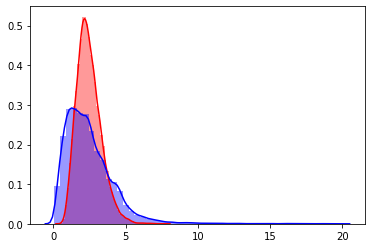

In [11]:
sns.distplot(v2,color='r',label='pred')
sns.distplot(t2,color='b',label='act')
plt.show()

Text(0, 0.5, 'actual icap kw')

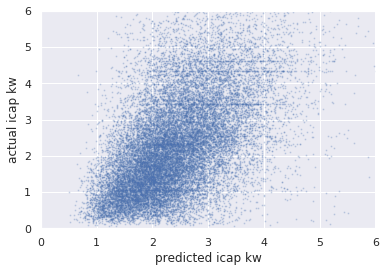

In [12]:
sns.set(style='darkgrid')
plt.scatter(v2,t2,alpha=0.2,s=1)
plt.xlim([0,6])
plt.ylim([0,6])
plt.xlabel("predicted icap kw")
plt.ylabel("actual icap kw")

In [13]:
mean_squared_error(t2,v2)

2.2012333715363632

In [14]:
np.save("light_icap_models.npy",oout[1])

In [15]:
fs = []
for i in oout[1]:
    feature_imp = pd.DataFrame(sorted(zip(i.feature_importance(),train.columns)), columns=['Value','Feature']).sort_values('Value',ascending=False).set_index("Feature")
    fs.append(feature_imp)

In [16]:
fsc = pd.concat(fs,axis=1)
fsc['avv'] = fsc.mean(axis=1)
pd.set_option('max_rows',1000)
fsc.sort_values('avv')

Value  Value  Value  Value  Value      avv
FuelDescription                    396    428    602    559    500    497.0
EducationLevel                    1097   1024   1431   1252   1140   1188.8
DwellingType                      1231   1236   1407   1245   1387   1301.2
HHSIZE                            1867   1710   2378   2001   1875   1966.2
Marital Status                    1791   1688   2289   2114   1967   1969.8
Mail Public Responder Indicator   1815   1826   2226   2080   1976   1984.6
state                             2249   2153   2729   2494   2453   2415.6
Home Ownership                    2558   2448   3007   2786   2655   2690.8
OccupationRollup                  2821   2488   3296   3054   2921   2916.0
Gender                            2999   2810   3475   3094   3065   3088.6
NetworthIndicator_Rollup          3636   3358   4347   4139   3842   3864.4
ESTINCOME                         4192   3878   5009   4565   4412   4411.2
SALE_PRICE                        9839   9606  11713  11056  11079  10658.6
UNIVERSAL_BUILDING_SQUARE_FEET   10454  10095  13368  12123  11336  11475.2
YEAR_BUILT                       11858  11622  15451  14517  12879  13265.4
ASSD_TOTAL_VALUE                 13138  12224  15018  13874  13488  13548.4
LAND_SQUARE_FOOTAGE_D            12933  12390  16053  14518  14061  13991.0
AGEOFINDIVIDUAL                  13173  12706  16706  14807  14423  14363.0
Home Value Range                 13500  12539  16202  15179  14815  14447.0
ASSD_LAND_VALUE                  14379  13537  16533  15512  15141  15020.4
median_income                    14710  13904  17447  15618  15078  15351.4
median_home_value                14168  14041  17867  16538  15470  15616.8
population                       15757  14580  18194  16760  16557  16369.6
longitude                        15884  15235  18253  17339  16942  16730.6
latitude                         16139  15034  19324  17678  16829  17000.8